# Quantifying Complexity Across 3GPP Releases  

> *“How much harder does it get to engineer a full‑stack implementation as the 3GPP standard evolves?”*  

This notebook answers the question by  

1. embedding every normative sentence of 3GPP Releases 8–18 (plus early Rel‑19) with a **domain‑tuned SBERT** model,  
2. computing five semantic‑complexity metrics for each Release,  
3. collapsing them into a single **Engineering‑Load Index (EFI / EELI)**, and  
4. visualising how the load has grown over fifteen years of standardisation.  




## 1. Data & Pre‑processing  

* **Corpora** – concatenated `*.docx/TS/TR` for the main radio‑access specs of each Release.  
* **Sentence splitting** – spaCy `en_core_web_lg` + manual fixes for ASN.1 blocks.  
* **Embedding** – `SBERT` . Maximum sequence length =512  token; longer sentences are window‑pooled.  

Datasets already reside in two CSVs:  

| file | purpose |
|------|---------|
| `release_metrics.csv` | per‑Release absolute metrics & sentence counts |
| `delta_metrics.csv`   | inter‑Release deltas (CM, ND) |


## 2. Complexity Metrics  


| Symbol | Name | Formula | Captures |
|--------|------|---------|----------|
| SS | *Semantic Spread* | $\operatorname{Tr}\!\bigl(\operatorname{Cov}(\mathbf{s})\bigr)$ | Breadth of semantic space |
| RI | *Redundancy Index* | $1-\bar{\,\cos(\mathbf{s}_i,\mathbf{s}_j)\,}$ | Non‑repetition |
| CE | *Cluster Entropy* | $H\_k = -\sum\_{c=1}^k p_c\log p_c$ (k‑means, $k\approx\sqrt N$) | Topic balance |
| CM | *Change Magnitude* | $1-\cos(\mu_r,\mu_{r+1})$ | Shift of centroid between Releases |
| ND | *Novelty Density* | $\displaystyle\frac1N\sum_i \min_j \|\mathbf{s}_i-\mathbf{s}_j^{(prev)}\|$ | Sentence‑level newness |  

All vectors $\mathbf{s}$ live in the SBERT 768‑D space.  


## 3. Star plot

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


release_df = pd.read_csv('release_metrics.csv')
delta_df   = pd.read_csv('delta_metrics.csv')
delta_df['transition'] = delta_df.apply(lambda r: f"{r['from']}→{r['to']}", axis=1)


### Semantic Spread (SS)

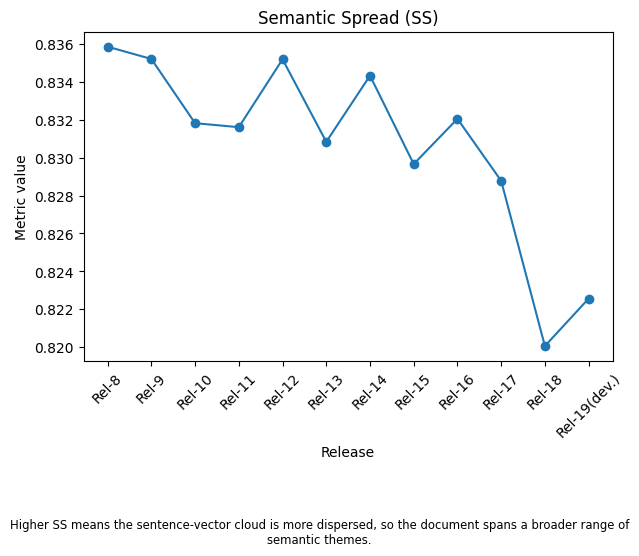

In [32]:

fig, ax = plt.subplots()
ax.plot(release_df['release'], release_df['semantic_spread'], marker='o')
ax.set_xlabel('Release')
ax.set_ylabel('Metric value')
ax.set_title('Semantic Spread (SS)')
plt.xticks(rotation=45)
fig.text(
    0.5, -0.12,
    'Higher SS means the sentence-vector cloud is more dispersed, so the document spans a broader range of semantic themes.',
    ha='center', va='center', fontsize='small', wrap=True
)
plt.tight_layout()
plt.show()



### Redundancy Index (RI)

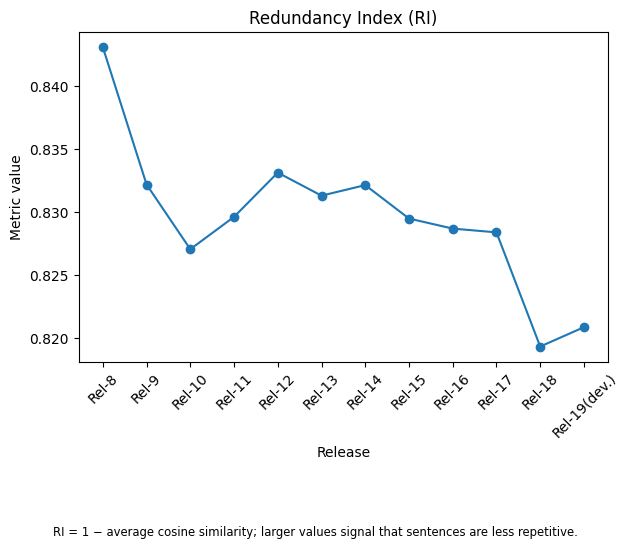

In [33]:
# Redundancy Index (RI)
fig, ax = plt.subplots()
ax.plot(release_df['release'], release_df['redundancy_index'], marker='o')
ax.set_xlabel('Release')
ax.set_ylabel('Metric value')
ax.set_title('Redundancy Index (RI)')
plt.xticks(rotation=45)
fig.text(
    0.5, -0.12,
    'RI = 1 − average cosine similarity; larger values signal that sentences are less repetitive.',
    ha='center', va='center', fontsize='small', wrap=True
)
plt.tight_layout()
plt.show()

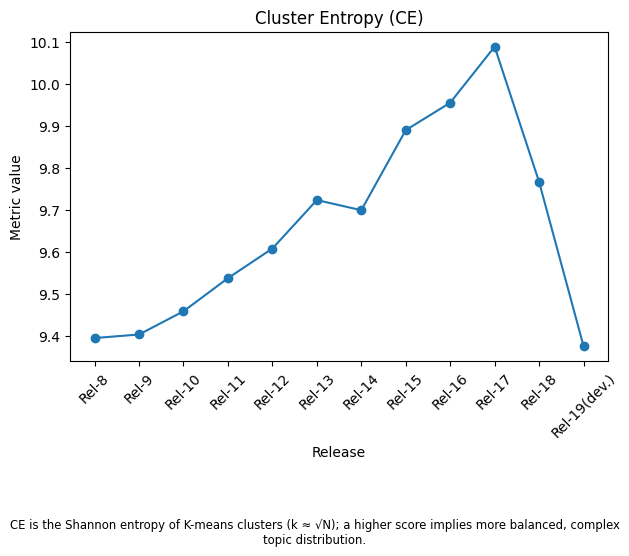

In [34]:
# Cluster Entropy (CE)
fig, ax = plt.subplots()
ax.plot(release_df['release'], release_df['cluster_entropy'], marker='o')
ax.set_xlabel('Release')
ax.set_ylabel('Metric value')
ax.set_title('Cluster Entropy (CE)')
plt.xticks(rotation=45)
fig.text(
    0.5, -0.12,
    'CE is the Shannon entropy of K-means clusters (k ≈ √N); a higher score implies more balanced, complex topic distribution.',
    ha='center', va='center', fontsize='small', wrap=True
)
plt.tight_layout()
plt.show()


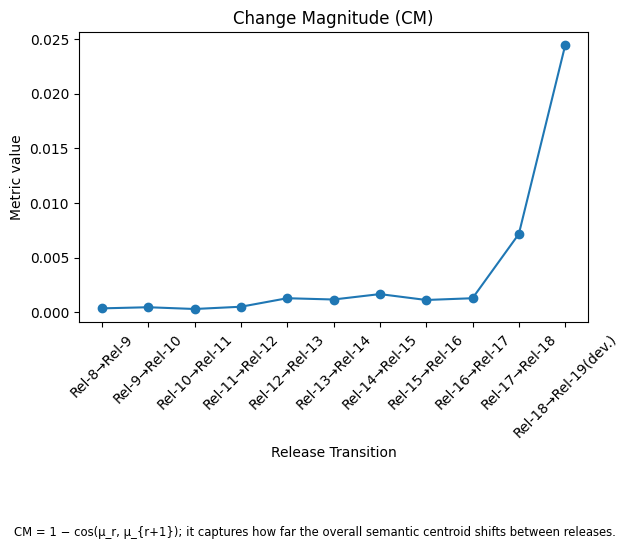

In [35]:
# Change Magnitude (CM)
fig, ax = plt.subplots()
ax.plot(delta_df['transition'], delta_df['change_magnitude'], marker='o')
ax.set_xlabel('Release Transition')
ax.set_ylabel('Metric value')
ax.set_title('Change Magnitude (CM)')
plt.xticks(rotation=45)
fig.text(
    0.5, -0.12,
    'CM = 1 − cos(μ_r, μ_{r+1}); it captures how far the overall semantic centroid shifts between releases.',
    ha='center', va='center', fontsize='small', wrap=True
)
plt.tight_layout()
plt.show()


# Novelty Density (ND)

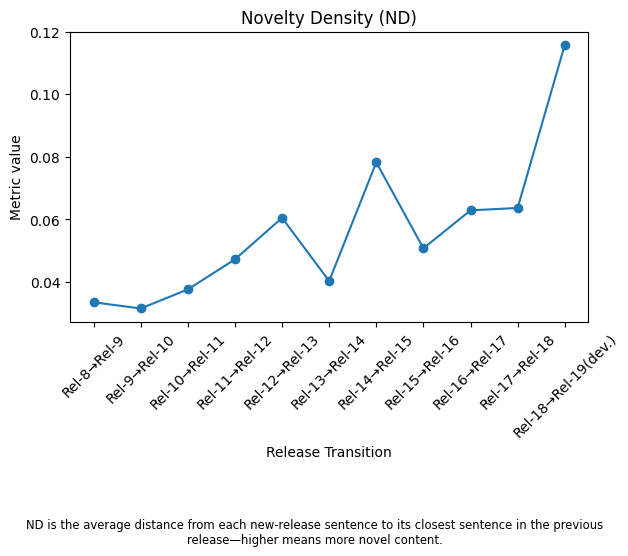

In [36]:
# Novelty Density (ND)
fig, ax = plt.subplots()
ax.plot(delta_df['transition'], delta_df['novelty_density'], marker='o')
ax.set_xlabel('Release Transition')
ax.set_ylabel('Metric value')
ax.set_title('Novelty Density (ND)')
plt.xticks(rotation=45)
fig.text(
    0.5, -0.12,
    'ND is the average distance from each new-release sentence to its closest sentence in the previous release—higher means more novel content.',
    ha='center', va='center', fontsize='small', wrap=True
)
plt.tight_layout()
plt.show()




### 1 Composite Metric

$$
\boxed{\; \mathrm{EFI}_r \;=\; S_r \;\times\; D_r \;\times\; \bigl(1 + V_r\bigr) \;}
$$

*EFI = Engineering Footprint Index for release **r** — a single number estimating end-to-end implementation effort.*

$$
\mathrm{EELI}_r \;=\; \log_{10}\!\bigl(\mathrm{EFI}_r\bigr)
$$

*EELI (Engineering Load Index) compresses EFI to a log scale; +1 ≈ 10 × more work.*

---

| Symbol   | Formula                                                                            | Captures                                                                                     | Typical range |
| -------- | ---------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- | ------------- |
| $S\_r$ | \$\log\_{10} N\_r\$                                                                | **Size** — quantity of normative “atoms” (sentences, pages, or words)                        | 3 – 5         |
| \$D\_r\$ | \$\displaystyle \frac{\mathrm{CE}\_r ,\mathrm{SS}\_r}{\mathrm{RI}\_r}\$            | **Diversity** — breadth & balance of topics after deducting redundancy                       | 1 – 12        |
| \$V\_r\$ | \$\displaystyle \alpha,\mathrm{CM}*{r-1!\to r} ;+; \beta,\mathrm{ND}*{r-1!\to r}\$ | **Velocity** — how much genuinely new or disruptive content appears vs. the previous release | 0 – 0.15      |





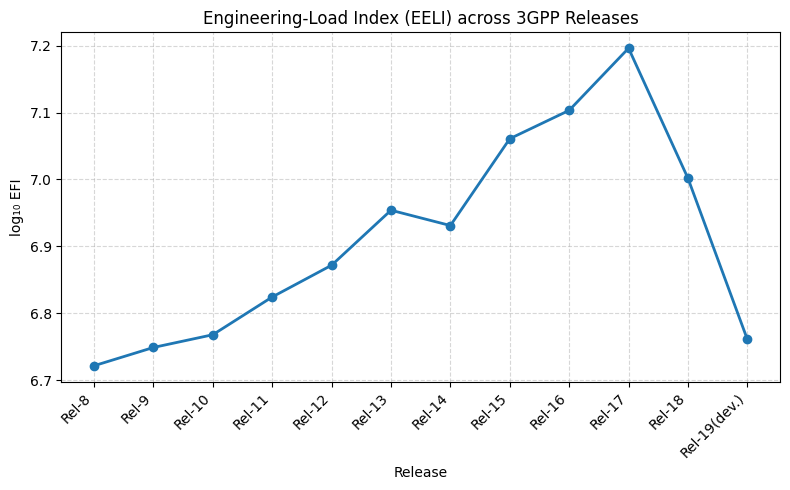

In [37]:

# 1)  -------  Compute the Engineering‑Footprint/Load Index (EFI + EELI)  ----

# Diversity term  D_r  =  CE × SS / RI
release_df['D'] = release_df['cluster_entropy'] * release_df['semantic_spread'] / release_df['redundancy_index']

# # Velocity term  V_r  =  α·CM + β·ND (taken from delta metrics, aligned by “to” release)
# --- 1) pick the weights -------------------------
ALPHA, BETA = 0.60, 0.40   

# --- 2) prepare delta-level velocity -----------------------------
delta_df["velocity"] = (ALPHA * delta_df["change_magnitude"] +
                        BETA   * delta_df["novelty_density"])

# --- 3) join velocity onto per-release table ---------------------
release_df = (
    release_df
      .merge(delta_df[["to", "velocity"]]
             .rename(columns={"to": "release"}),        # align on *current* release
             on="release", how="left")
      .fillna({"velocity": 0.0})                       # Rel-8 (or first row) gets 0
)

# Engineering‑Footprint Index  EFI_r  =  Size × Diversity × (1+Velocity)
release_df['EFI']  = release_df['sentences'] * release_df['D'] * (1.0 + release_df['velocity'])
release_df['EELI'] = np.log10(release_df['EFI'])              # log‑scaled for readability

# -----  Plot #1 : EELI vs Release  -----
plt.figure(figsize=(8,5))
plt.plot(release_df['release'], release_df['EELI'], marker='o', linewidth=2)
plt.title('Engineering‑Load Index (EELI) across 3GPP Releases')
plt.ylabel('log\u2081\u2080 EFI')
plt.xlabel('Release')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Constructing a Composite Index: EFI

We define the **Engineering-Footprint Index (EFI)** for release *r* as:

$$
\text{EFI}_r = S_r \cdot D_r \cdot (1 + V_r)
$$

Where:

* $S_r$: **Scale** – the overall volume of features to implement
* $D_r$: **Diversity** – the degree of heterogeneity across functionalities
* $V_r$: **Velocity** – the relative rate of newly added features

This is a **linear multiplicative** model that combines the three dimensions of engineering complexity.

---

### Exponential Trend:

* In practice, $S_r$ tends to **increase linearly** over time.
* $D_r$ rises slowly at first and then plateaus, but **remains >1**.
* $V_r$ **spikes sharply** before and after each major generational shift (e.g., 4G → 5G).

When combined, these factors produce an **approximately exponential or stepwise escalation** in EFI, which from an engineering perspective explains the **explosion in the testing matrix**.

---

### Logarithmic Visualization:

To aid interpretation, we define the **Engineering Effort Log-Index (EELI)** as the base-10 logarithm of EFI:

$$
\text{EELI}_r = \log_{10}(\text{EFI}_r)
$$

This transformation makes it easier to visualize and compare engineering burdens across different 3GPP releases.

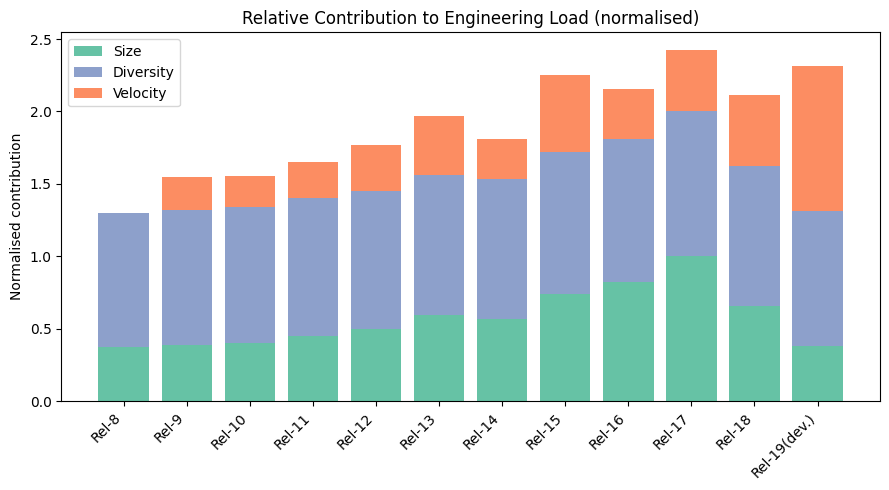

In [38]:
# 2)  -------  Stacked bar showing the relative contribution of Size / Diversity / Velocity  -----
#   (Normalised so all bars have a comparable scale)
max_S = release_df['sentences'].max()
max_D = release_df['D'].max()
max_V = release_df['velocity'].max()

stack_df = pd.DataFrame({
    'Release'   : release_df['release'],
    'Size'      : release_df['sentences'] / max_S,
    'Diversity' : release_df['D']         / max_D,
    'Velocity'  : release_df['velocity']  / max_V,
})

plt.figure(figsize=(9,5))
bottom = np.zeros(len(stack_df))
for col, colour in zip(['Size', 'Diversity', 'Velocity'],
                       ['#66c2a5', '#8da0cb', '#fc8d62']):
    plt.bar(stack_df['Release'], stack_df[col], bottom=bottom,
            label=col, color=colour)
    bottom += stack_df[col]

plt.title('Relative Contribution to Engineering Load (normalised)')
plt.ylabel('Normalised contribution')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



### **3GPP Release Mapping Table**

| Release | Key Features                                  | Corresponding Generation | Release Year       |
| ------- | --------------------------------------------- | ------------------------ | ------------------ |
| Rel-8   | Introduction of **LTE (Long Term Evolution)** | Initial 4G               | 2008               |
| Rel-9   | LTE enhancements (e.g., Dual-layer MIMO)      | 4G                       | 2009               |
| Rel-10  | Introduction of **LTE-Advanced**              | Enhanced 4G              | 2011               |
| Rel-11  | Enhanced Carrier Aggregation                  | 4G                       | 2012               |
| Rel-12  | Support for D2D, Small Cells, etc.            | 4G / Transitional        | 2014               |
| Rel-13  | LTE-Advanced Pro (e.g., NB-IoT)               | 4.5G / Pre-5G            | 2016               |
| Rel-14  | V2X, eMTC, and more                           | 4.5G                     | 2017               |
| Rel-15  | **First 5G NR Standard** (NSA/SA)             | **Initial 5G**           | 2018               |
| Rel-16  | 5G enhancements (e.g., URLLC, V2X)            | 5G                       | 2020               |
| Rel-17  | 5G expansion (e.g., RedCap, NTN)              | Enhanced 5G              | 2022               |
| Rel-18  | **First phase of 5G-Advanced**                | 5.5G                     | 2024      |
| Rel-19  | **Second phase of 5G-Advanced**               | 5.5G / Towards 6G        | Expected 2025–2026 |

---

### Summary:

* **Rel-8 to Rel-14**: Mainly cover **4G LTE and its evolution** (also known as LTE-A, LTE-A Pro).
* **Rel-15 to Rel-17**: Represent various stages of **5G NR (New Radio)**.
* **Rel-18 to Rel-19**: Fall under **5G-Advanced (5.5G)** and serve as a **stepping stone toward 6G**.
* **Releases prior to Rel-6/Rel-7**: Primarily represent **3G (UMTS/HSPA)**.
